## Define Area of Interest (AOI)

Use the map below to draw a rectangle defining your processing area. The maximum size is approximately 600x600 pixels at 10m resolution.

In [1]:
import openeo
from extractor import load_input_WAC
from inference import inference_WAC


CRS = "EPSG:3035"
RESOLUTION = 10  # important; the resolution is implicitely tied to the CRS; so we need to use UTM based CRS here

SPATIAL_EXTENT = {
    'west': 300000,
    'south': 9800000,
    'east': 305000,  
    'north': 9805000,  
    'crs': CRS  
}

TEMPORAL_EXTENT = ['2023-06-01', '2023-08-01'] #Sentinel 1 mosiac needs a buffer of 1 day, here processing for january
MAX_CLOUD_COVER = 85


JOB_OPTIONS = {'driver-memory': '1000m',
 'driver-memoryOverhead': '1000m',
 'executor-memory': '1500m',
 'executor-memoryOverhead': '1500m',
 'python-memory': '8000m',
 'max-executors': 20,
 "udf-dependency-archives": [
        "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/onnx_dependencies_1.16.3.zip#onnx_deps",
        "https://s3.waw3-1.cloudferro.com/swift/v1/project_dependencies/WAC_model_hansvrp.zip#onnx_models"
        ]
 }


In [2]:

connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()

input_cube = load_input_WAC(connection, SPATIAL_EXTENT, TEMPORAL_EXTENT, MAX_CLOUD_COVER, RESOLUTION, CRS)
inference_cube = inference_WAC(input_cube)

save_cube = inference_cube.save_result(format = "netCDF")
job = connection.create_job([save_cube],
    additional=JOB_OPTIONS
)

job.start_and_wait()



Authenticated using refresh token.
0:00:00 Job 'j-2505261329594e4c925a6ab067957af7': send 'start'
0:00:13 Job 'j-2505261329594e4c925a6ab067957af7': queued (progress 0%)
0:00:18 Job 'j-2505261329594e4c925a6ab067957af7': queued (progress 0%)
0:00:25 Job 'j-2505261329594e4c925a6ab067957af7': queued (progress 0%)
0:00:33 Job 'j-2505261329594e4c925a6ab067957af7': queued (progress 0%)
0:00:43 Job 'j-2505261329594e4c925a6ab067957af7': queued (progress 0%)
0:00:55 Job 'j-2505261329594e4c925a6ab067957af7': queued (progress 0%)
0:01:10 Job 'j-2505261329594e4c925a6ab067957af7': running (progress N/A)
0:01:30 Job 'j-2505261329594e4c925a6ab067957af7': running (progress N/A)
0:01:54 Job 'j-2505261329594e4c925a6ab067957af7': running (progress N/A)
0:02:24 Job 'j-2505261329594e4c925a6ab067957af7': running (progress N/A)
0:03:01 Job 'j-2505261329594e4c925a6ab067957af7': running (progress N/A)
0:03:48 Job 'j-2505261329594e4c925a6ab067957af7': running (progress N/A)
0:04:47 Job 'j-2505261329594e4c925a6ab

<BatchJob job_id='j-2505261329594e4c925a6ab067957af7'>

In [3]:
import xarray as xr 
OUTPUT_DIR = "C:/Git_projects/WAC/production/prediction/" + job.job_id
OUTPUT_FILE = f"{OUTPUT_DIR}/openEO.nc"

# --- Download Results ---
job.get_results().download_files(OUTPUT_DIR)




[WindowsPath('C:/Git_projects/WAC/production/prediction/j-2505261329594e4c925a6ab067957af7/openEO.nc'),
 WindowsPath('C:/Git_projects/WAC/production/prediction/j-2505261329594e4c925a6ab067957af7/job-results.json')]

In [5]:
ds = xr.open_dataset(OUTPUT_FILE)
ds

<xarray.Dataset> Size: 88MB
Dimensions:         (t: 2, x: 500, y: 500)
Coordinates:
  * t               (t) datetime64[ns] 16B 2023-06-01 2023-07-01
  * x               (x) float64 4kB 3e+05 3e+05 3e+05 ... 3.05e+05 3.05e+05
  * y               (y) float64 4kB 9.805e+06 9.805e+06 ... 9.8e+06 9.8e+06
Data variables: (12/23)
    crs             |S1 1B ...
    VV              (t, y, x) float64 4MB ...
    VH              (t, y, x) float64 4MB ...
    B02             (t, y, x) float64 4MB ...
    B03             (t, y, x) float64 4MB ...
    B04             (t, y, x) float64 4MB ...
    ...              ...
    unkown_band_16  (t, y, x) float64 4MB ...
    unkown_band_17  (t, y, x) float64 4MB ...
    unkown_band_18  (t, y, x) float64 4MB ...
    unkown_band_19  (t, y, x) float64 4MB ...
    unkown_band_20  (t, y, x) float64 4MB ...
    unkown_band_21  (t, y, x) float64 4MB ...
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.66.0a3.dev20...
    description:  
    title:

KeyError: "No variable named 'unkown_band_10'. Variables on the dataset include ['t', 'x', 'y', 'crs', 'VV', ..., 'unkown_band_17', 'unkown_band_18', 'unkown_band_19', 'unkown_band_20', 'unkown_band_21']"

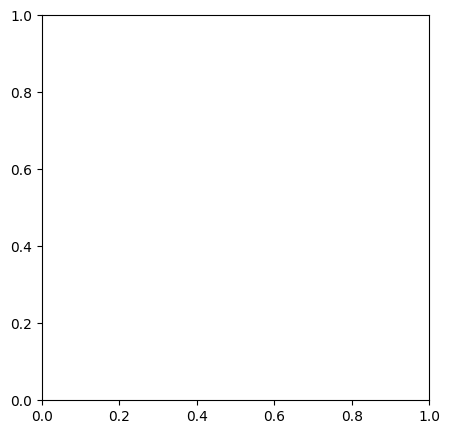

In [4]:
import matplotlib.pyplot as plt

# --- Open Dataset ---
ds = xr.open_dataset(OUTPUT_FILE)
band_name = 'unkown_band_10'  # or 'unknown_band_1'

# Loop through each timestep
for i, t in enumerate(ds['t']):
    fig, ax = plt.subplots(figsize=(5, 5))  # Single subplot

    band = ds[band_name].sel(t=t)
    band.plot(ax=ax, cmap='grey')
    
    ax.set_title(f'{band_name} at {str(t.values)[:10]}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    plt.tight_layout()
    plt.show()